### This Notebook is to test the Monte Carlo facilities of PyNeb. It is aimed to compare results obtained with keyword 'orig', which are the results using the original data, with the results obtained with keyword 'median'. All the getCrossTemDen are made using Machine Learning. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyneb as pn

In [2]:
%load_ext autoreload
%aimport pipeline
%autoreload 1

warng EmissionLine: Atom N2r not valid
warng EmissionLine: line 4649A for atom O2r not valid
warng EmissionLine: line 4662A for atom O2r not valid
warng EmissionLine: Atom C2r not valid
warng EmissionLine: Atom N2r not valid
warng EmissionLine: Atom N2r not valid
warng EmissionLine: line 6461A for atom C2 not valid
warng EmissionLine: line 7004A for atom O4 not valid
warng EmissionLine: line 7005A for atom Ne5 not valid
warng EmissionLine: Atom O1r not valid
warng EmissionLine: Atom O1r not valid
warng EmissionLine: Atom O1r not valid
warng EmissionLine: line 8733A for atom He1r not valid
warng EmissionLine: line 8750A for atom H1r not valid
     addMonteCarloObs: Entering
     addMonteCarloObs: Leaving


/Users/jogarcia/opt/anaconda3/lib/python3.8/site-packages/pyneb/core/pynebcore.py:4607: RuntimeWarning: divide by zero encountered in true_divide
  obs_over_theo = (line1.obsIntens / line2.obsIntens) / r_theo
/Users/jogarcia/opt/anaconda3/lib/python3.8/site-packages/pyneb/core/pynebcore.py:4045: RuntimeWarning: invalid value encountered in multiply
  self.corrIntens = self.obsIntens * RC.getCorr(self.wave, normWave)


     PipeLine.red_cor_obs: number of spaxels with EBV < 0.0 : 37491


/Users/jogarcia/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-4-97bba42ea425>:12: RuntimeWarning: invalid value encountered in true_divide
  image = PL.get_image(PL.obs.extinction.cHbeta, type_='orig') / PL.get_image(PL.obs.extinction.cHbeta, type_='median')


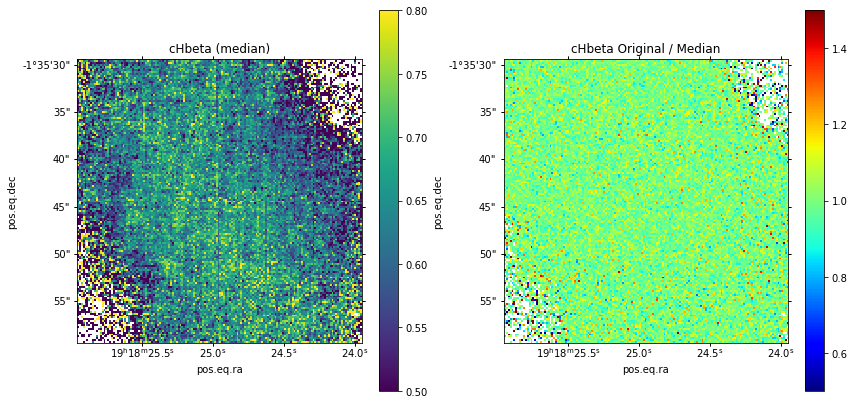

In [4]:
pn.log_.level = 3
data_dir='/Users/jogarcia/Dropbox/MUSE_data/hektor_fits/ngc6778_maps/ngc6778_long_maps/'
image_dir=data_dir+'/linemaps/'
image_name='ngc6778_MUSE_'
PL = pipeline.PipeLine(data_dir=data_dir,
                       name = image_name,
                       error_str='_error')
PL.add_MC(50)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), subplot_kw={'projection': PL.wcs})
PL.red_cor_obs(EBV_min = 0., plot_=True, ax=ax1, vmin=0.5, vmax=.8, title='cHbeta (median)',
        label_cut=('H1r_6563A', 'H1r_4861A'), SN_cut=2.5)
image = PL.get_image(PL.obs.extinction.cHbeta, type_='orig') / PL.get_image(PL.obs.extinction.cHbeta, type_='median')
PL.plot(ax=ax2, image=image, vmin=0.5, vmax=1.5, cmap='jet', title='cHbeta Original / Median',
        label_cut=('H1r_6563A', 'H1r_4861A'), SN_cut=2.5)

In [5]:
PL.obs.lines

[Line N2r N2r_4641A,
 Line O2r O2r_4649A,
 Line Fe3 Fe3_4659A,
 Line O2r O2r_4662A,
 Line He2r He2r_4686A,
 Line Ar4 Ar4_4711A,
 Line He1r He1r_4713A,
 Line Ar4 Ar4_4740A,
 Line H1r H1r_4861A,
 Line O3 O3_4959A,
 Line N1 N1_5200A,
 Line C2r C2r_5342A,
 Line Cl3 Cl3_5518A,
 Line Cl3 Cl3_5538A,
 Line N2r N2r_5676A,
 Line N2r N2r_5679A,
 Line N2 N2_5755A,
 Line He1r He1r_5876A,
 Line O1 O1_6300A,
 Line S3 S3_6312A,
 Line O1 O1_6364A,
 Line C2 C2_6461A,
 Line N2 N2_6548A,
 Line H1r H1r_6563A,
 Line N2 N2_6584A,
 Line He1r He1r_6678A,
 Line S2 S2_6716A,
 Line S2 S2_6731A,
 Line O4 O4_7004A,
 Line Ne5 Ne5_7005A,
 Line He1r He1r_7065A,
 Line Ar3 Ar3_7136A,
 Line O2 O2_7320A,
 Line O2 O2_7330A,
 Line Cl4 Cl4_7531A,
 Line Ar3 Ar3_7751A,
 Line O1r O1r_7771A,
 Line O1r O1r_7773A,
 Line O1r O1r_7775A,
 Line Cl4 Cl4_8046A,
 Line C1 C1_8728A,
 Line He1r He1r_8733A,
 Line H1r H1r_8750A,
 Line S3 S3_9069A,
 Line H1r H1r_9229A]

/Users/jogarcia/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


0.6300024516572329


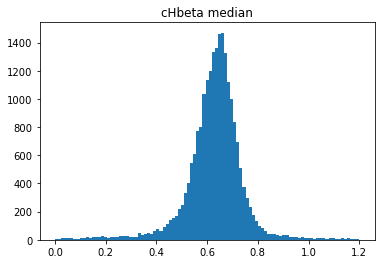

In [6]:
f, ax = plt.subplots()
ax.hist(PL.get_image(PL.obs.extinction.cHbeta, type_='median').ravel(), bins=np.linspace(0, 1.2, 100))
ax.set_title('cHbeta median')
print(np.nanmedian(PL.obs.extinction.cHbeta));

/Users/jogarcia/Dropbox/MUSE_data/hektor_fits/pipeline.py:177: RuntimeWarning: divide by zero encountered in true_divide
  mask = np.zeros_like(self.get_image(data = 1./self.obs.getError()[label[0]], type_='orig'), dtype=bool)
/Users/jogarcia/Dropbox/MUSE_data/hektor_fits/pipeline.py:185: RuntimeWarning: divide by zero encountered in true_divide
  mask = self.get_image(data = 1./self.obs.getError()[label], type_='orig') < SN_cut
/Users/jogarcia/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/jogarcia/Dropbox/MUSE_data/hektor_fits/pipeline.py:141: RuntimeWarning: divide by zero encountered in true_divide
  return self.get_image(label=label[0], type_=type_) / self.get_image(label=label[1], type_=type_)
/Users/jogarcia/Dropbox/MUSE_data/hektor_fits/pipeline.py:141: RuntimeWarning: invalid value encountered in true_divide
  return self.get_image

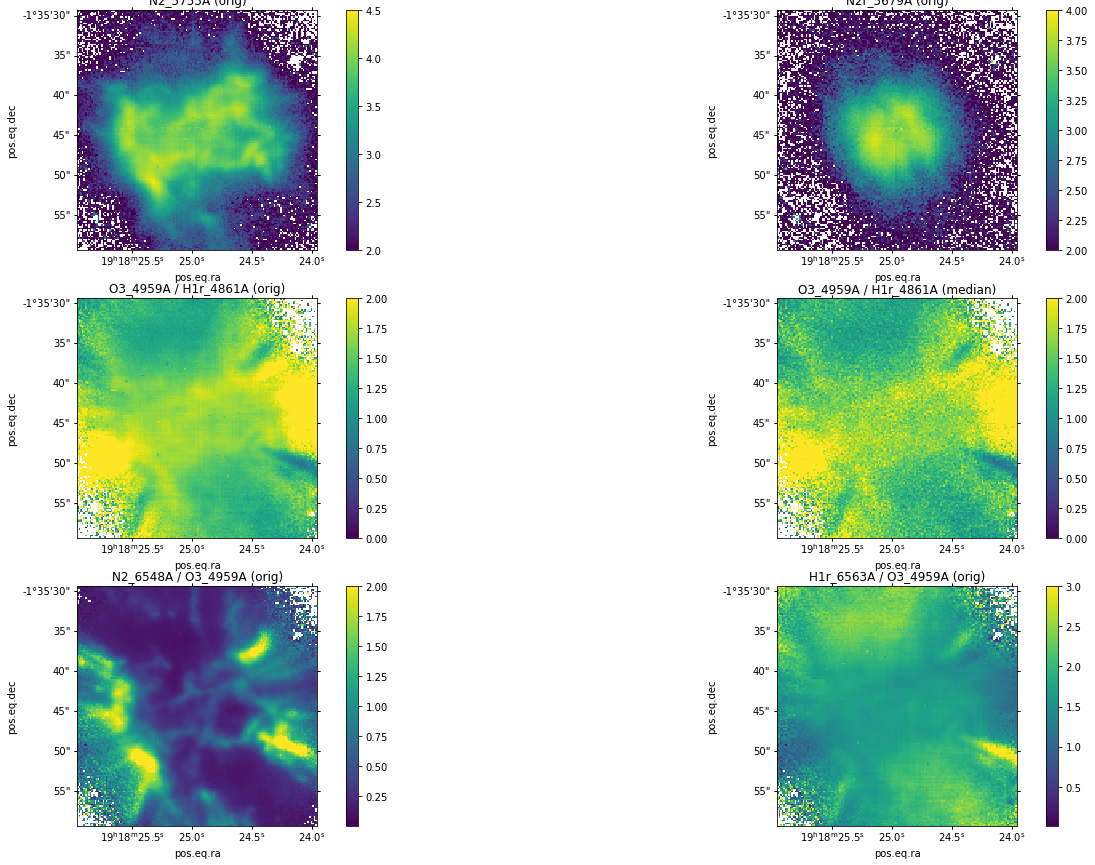

In [10]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(23, 15), subplot_kw={'projection': PL.wcs})
PL.plot(ax=ax1, label='N2_5755A', type_='orig', use_log=True, vmin=2, vmax=4.5, SN_cut=None)
PL.plot(ax=ax2, label='N2r_5679A', type_='orig', use_log=True, vmin=2, vmax=4., SN_cut=None)
PL.plot(ax=ax3, label=('O3_4959A', 'H1r_4861A'), type_='orig', vmax=2, SN_cut=(2.5, 2.5))
PL.plot(ax=ax4, label=('O3_4959A', 'H1r_4861A'), type_='median', vmax=2, SN_cut=(2.5, 2.5))
PL.plot(ax=ax5, label=('N2_6548A', 'O3_4959A'), type_='orig', vmax=2, SN_cut=(2.5, 2.5))
PL.plot(ax=ax6, label=('H1r_6563A', 'O3_4959A'), type_='orig', vmax=3, SN_cut=(2.5, 2.5))

In [57]:
pn.log_.level=2
PL.make_diags()
#PL.diags.addDiag('HeI 6678/5876', ('HeIr', "S('6678')/S('5876')", "RMS([SE('6678'), SE('5876')])"))
PL.diags.diags

warng Observation: No line for O2_3727A+ from NoneNone at wavelength None (blend=False)


{'[NII] 5755/6548': ('N2', 'L(5755)/L(6548)', 'RMS([E(6548), E(5755)])'),
 '[NII] 5755/6584': ('N2', 'L(5755)/L(6584)', 'RMS([E(6584), E(5755)])'),
 '[NII] 5755/6584+': ('N2',
  'L(5755)/(L(6548)+L(6584))',
  'RMS([E(6548)*L(6548)/(L(6548)+L(6584)), E(6584)*L(6584)/(L(6584)+L(6548)), E(5755)])'),
 '[SII] 6731/6716': ('S2', 'L(6731)/L(6716)', 'RMS([E(6716), E(6731)])'),
 '[SIII] 6312/9069': ('S3', 'L(6312)/L(9069)', 'RMS([E(9069), E(6312)])'),
 '[ClIII] 5538/5518': ('Cl3', 'L(5538)/L(5518)', 'RMS([E(5518), E(5538)])'),
 '[ArIV] 4740/4711': ('Ar4', 'L(4740)/L(4711)', 'RMS([E(4711), E(4740)])')}

In [31]:
PL.diags.ANN_inst_kwargs['verbose']=True
PL.diags.ANN_init_kwargs['activation']='tanh' #identity’, ‘logistic’, ‘tanh’, ‘relu’
PL.diags.ANN_init_kwargs['solver']= 'lbfgs' #‘lbfgs’, ‘sgd’, ‘adam’
PL.diags.ANN_init_kwargs['hidden_layer_sizes'] = (10, 20, 10)

print(PL.n_obs)
pn.log_.timer('Starting', quiet=True)
PL.add_gCTD('N2S2', '[NII] 5755/6548', '[SII] 6731/6716')
PL.add_gCTD('N2S2_84', '[NII] 5755/6584', '[SII] 6731/6716')
PL.add_gCTD('S3Cl3', '[SIII] 6312/9069', '[ClIII] 5538/5518')
PL.add_gCTD('S3S2', '[SIII] 6312/9069', '[SII] 6731/6716')
PL.add_gCTD('S3Ar4', '[SIII] 6312/9069', '[ArIV] 4740/4711')
pn.log_.timer('ANN getCrossTemDen done')

1147500
   None: ANN getCrossTemDen done in 3.774683952331543


/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:184: RuntimeWarning: divide by zero encountered in true_divide
  mask = self.get_image(data = 1./self.obs.getError()[label], type_='orig') < SN_cut
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:176: RuntimeWarning: divide by zero encountered in true_divide
  mask = np.zeros_like(self.get_image(data = 1./self.obs.getError()[label[0]], type_='orig'), dtype=bool)


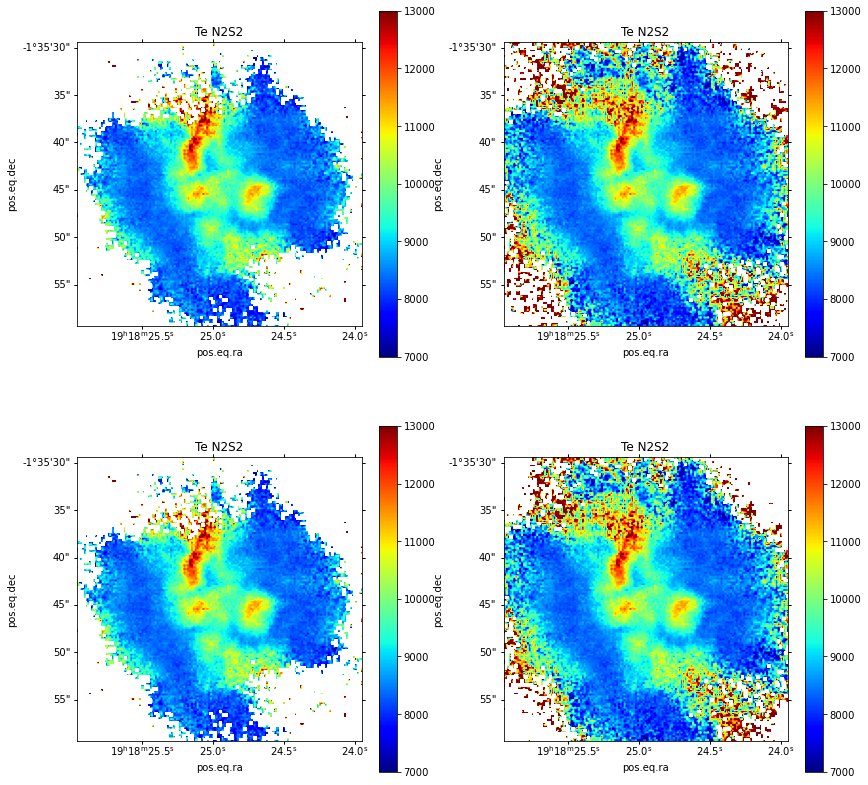

In [32]:
SN_cut = 2.5
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, subplot_kw={'projection': PL.wcs}, figsize=(14,14))
PL.plot(ax=ax1, data=PL.TeNe['N2S2']['Te'], title='Te N2S2', vmin=7000, vmax=13000, cmap='jet', 
        label_cut=('N2_6548A', 'N2_5755A', 'S2_6716A', 'S2_6731A'), SN_cut=SN_cut)
PL.plot(ax=ax2, data=PL.TeNe['N2S2']['Te'], title='Te N2S2', vmin=7000, vmax=13000, cmap='jet', 
        label_cut=('N2_6548A'), SN_cut=SN_cut)
PL.plot(ax=ax3, data=PL.TeNe['N2S2']['Te'], title='Te N2S2', vmin=7000, vmax=13000, cmap='jet', 
        label_cut=('N2_5755A'), SN_cut=SN_cut)
PL.plot(ax=ax4, data=PL.TeNe['N2S2']['Te'], title='Te N2S2', vmin=7000, vmax=13000, cmap='jet', 
        label_cut=('S2_6716A', 'S2_6731A'), SN_cut=SN_cut)


/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:184: RuntimeWarning: divide by zero encountered in true_divide
  mask = self.get_image(data = 1./self.obs.getError()[label], type_='orig') < SN_cut
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:176: RuntimeWarning: divide by zero encountered in true_divide
  mask = np.zeros_like(self.get_image(data = 1./self.obs.getError()[label[0]], type_='orig'), dtype=bool)


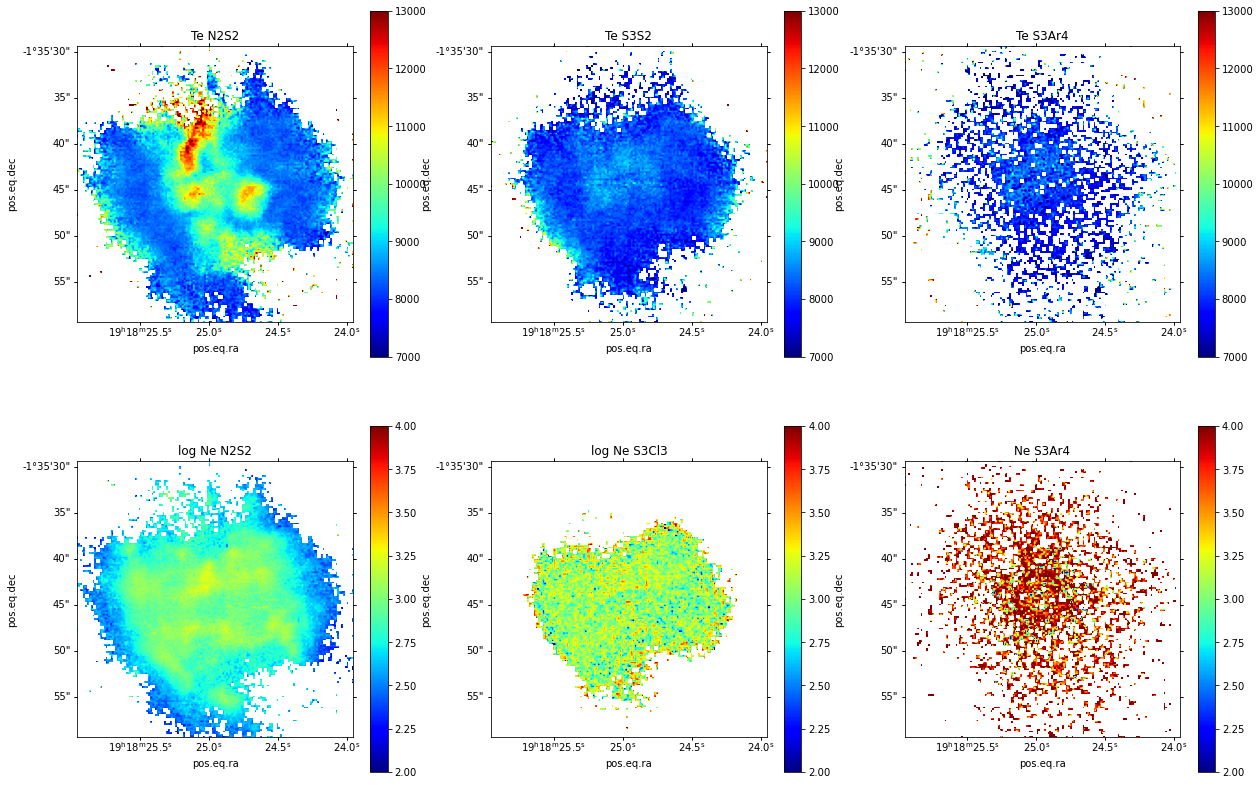

In [33]:
SN_cut = 2.5
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, subplot_kw={'projection': PL.wcs}, figsize=(21,14))
PL.plot(ax=ax1, data=PL.TeNe['N2S2']['Te'], title='Te N2S2', vmin=7000, vmax=13000, cmap='jet', 
        label_cut=('N2_6548A', 'N2_5755A', 'S2_6716A', 'S2_6731A'), SN_cut=SN_cut)
PL.plot(ax=ax2, data=PL.TeNe['S3S2']['Te'], title='Te S3S2', vmin=7000, vmax=13000, cmap='jet', 
        label_cut=('S3_9069A', 'S3_6312A', 'S2_6716A', 'S2_6731A'), SN_cut=SN_cut)
PL.plot(ax=ax3, data=PL.TeNe['S3Ar4']['Te'], title='Te S3Ar4', vmin=7000, vmax=13000, cmap='jet', 
        label_cut=('S3_9069A', 'S3_6312A', 'Ar4_4711A', 'Ar4_4740A'), SN_cut=None)
PL.plot(ax=ax4, data=np.log10(PL.TeNe['N2S2']['Ne']), title='log Ne N2S2', vmin=2, vmax=4, cmap='jet', 
        label_cut=('N2_6548A', 'N2_5755A', 'S2_6716A', 'S2_6731A'), SN_cut=SN_cut)
PL.plot(ax=ax5, data=np.log10(PL.TeNe['S3Cl3']['Ne']), title='log Ne S3Cl3', vmin=2, vmax=4, cmap='jet', 
        label_cut=('S3_9069A', 'S3_6312A', 'Cl3_5518A', 'Cl3_5538A'), SN_cut=SN_cut)
PL.plot(ax=ax6, data=np.log10(PL.TeNe['S3Ar4']['Ne']), title='Ne S3Ar4', vmin=2, vmax=4, cmap='jet', 
        label_cut=('S3_9069A', 'S3_6312A', 'Ar4_4711A', 'Ar4_4740A'), SN_cut=None)

/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


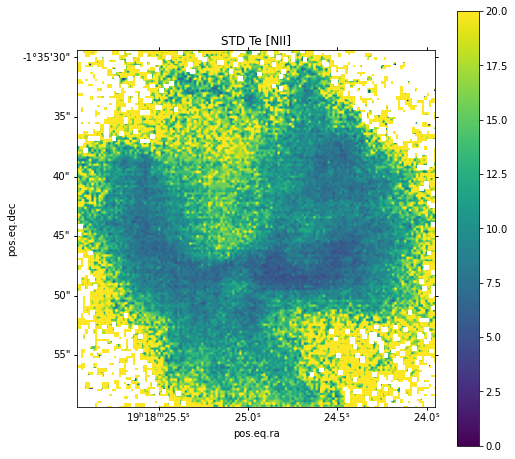

In [40]:
PL.plot_STD(data=PL.TeNe['N2S2']['Te'], vmin=0, vmax=20, title='STD Te [NII]')

/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/christophemorisset/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/christophemorisset/Google Drive/Pro/MUSE_PNe/pipeline.py:184: RuntimeWarning: divide by zero encountered in true_divide
  mask = self.get_image(data = 1./self.obs.getError()[label], type_='orig') < SN_cut


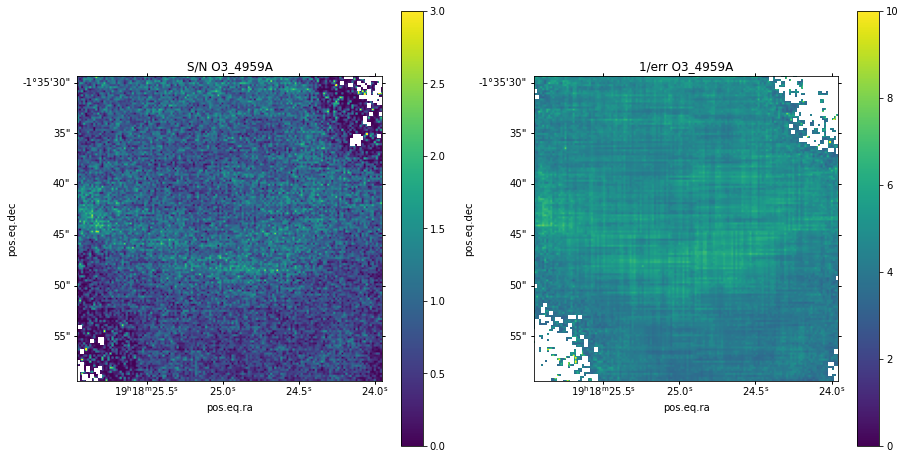

In [46]:
label = 'O3_4959A'
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), subplot_kw={'projection': PL.wcs})
PL.plot_SN(label = label, ax=ax1,vmin=0, vmax=3)
PL.plot(data = 1./PL.obs.getError()[label], type_='orig', vmin=0,vmax=10., ax=ax2, title='1/err {}'.format(label),
       label_cut=label, SN_cut=3)